In [9]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict, is_dataclass, dataclass
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from typing import Dict, List
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import bisect

from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.predictionModule.ConditionalML import ConditionalML
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO
from src.predictionModule.CollectionModels import CollectionModels
from src.common.AssetFileInOut import AssetFileInOut

from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.predictionModule.ModelAnalyzer import ModelAnalyzer

from src.featureAlchemy.FeatureMain import FeatureMain
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPolars as DPl


In [11]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_finanTo2011")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [12]:
conditionalML = ConditionalML(assetspl)

In [13]:
loadup_name = "ConditionalML_debug_oneMonthAfter_Over5perc_LeakageCheck"
conditionalML.load_data('../src/predictionModule/bin', loadup_name)

conditionalML.loadLGBMModel('../src/predictionModule/bin', loadup_name+"_lgbmModel")

print(conditionalML.metadata)

Data and metadata loaded from ../src/predictionModule/bin\ConditionalML_debug_oneMonthAfter_Over5perc_LeakageCheck.pkl
Model loaded from ../src/predictionModule/bin\ConditionalML_debug_oneMonthAfter_Over5perc_LeakageCheck_lgbmModel.pkl
{'Condtional_params': {'idxLengthOneMonth': 21, 'fouriercutoff': 5, 'multFactor': 6, 'daysAfterPrediction': 21, 'monthsHorizon': 6, 'timesteps': 5, 'classificationInterval': [0.05], 'averageOverDays': 5, 'optuna_trials': 4, 'LGBM_max_depth': 15}, 'LGBMModel_params': {'verbosity': -1, 'n_jobs': -1, 'boosting_type': 'gbdt', 'early_stopping_rounds': 100, 'n_estimators': 113, 'lambda_l1': 0.9, 'lambda_l2': 0.9, 'num_leaves': 141, 'max_depth': 15, 'learning_rate': 0.30210533013800284}, 'LGBMModel_accuracy_val': 0.7357694163048721, 'LGBMModel_log_loss_val': 0.5402422921371698, 'LGBMModel_accuracy_test': 0.6346787479406919, 'LGBMModel_log_loss_test': 0.8140712599546737}


In [15]:
X_train = pd.DataFrame(conditionalML.X_train, columns=conditionalML.featureColumnNames)

X_train.shape

(34427, 1695)

In [8]:
dateStart = pd.Timestamp(year=2024, month=11, day=10, tz="UTC")
dateEnd = pd.Timestamp(year=2024, month=11, day=15, tz="UTC")
date_range = pd.date_range(dateStart, dateEnd, freq='B')
predLabel = {}
probaLabel = {}
y_test = []
y_pred = []
y_proba = []
for ticker, asset in assetspl.items():
    if asset.adjClosePrice is None or not 'AdjClose' in asset.adjClosePrice.columns:
        continue
    
    daysAfterPrediction = conditionalML.metadata['Condtional_params']['daysAfterPrediction']
    averageOverDays = conditionalML.metadata['Condtional_params']['averageOverDays']
    classificationInterval = conditionalML.metadata['Condtional_params']['classificationInterval']
    
    params = {
        'idxLengthOneMonth': 21,
        'fouriercutoff': conditionalML.metadata['Condtional_params']['fouriercutoff'],
        'multFactor': conditionalML.metadata['Condtional_params']['multFactor'],
        'monthsHorizon': conditionalML.metadata['Condtional_params']['monthsHorizon'],
        'timesteps': conditionalML.metadata['Condtional_params']['timesteps'],
    }
    
    featureMain = FeatureMain(
        asset, 
        date_range.min(), 
        date_range.max(),
        lagList = [1,2,3,5,10,21,63, 121, 210, 21*12], 
        params=params,
        enableTimeSeries = False
    )
    
    print(f"Ticker: {ticker}")
    for date in date_range:
        aidx = DPl(asset.shareprice).getNextLowerOrEqualIndex(date)
        if asset.shareprice["Date"].item(aidx) != date:
            print(f"For Ticker {ticker} Date not found")
            continue

        curPrice = asset.shareprice["Close"].item(aidx)
        mMonthPrice = asset.shareprice["Close"].item(aidx - conditionalML.idxLengthOneMonth)
        curAdjPrice = asset.adjClosePrice["AdjClose"].item(aidx)
        mMonthAdjPrice = asset.adjClosePrice["AdjClose"].item(aidx - conditionalML.idxLengthOneMonth)
        futurePrices = (
            asset.shareprice["Close"]
                .slice(aidx + daysAfterPrediction - averageOverDays//2, averageOverDays).to_numpy()
        )
        futureMeanPrice = futurePrices.mean()
        futureMeanPriceScaled = futureMeanPrice/curPrice
        label = [bisect.bisect_right(classificationInterval, value) for value in [futureMeanPriceScaled-1]]
        label = label[0]
        
        if not (curAdjPrice/mMonthAdjPrice) > 1.05:
            continue
        
        features = featureMain.apply(date, idx=aidx)
        predLabel[ticker] = conditionalML.LGBMModel.predict(features.reshape(1, -1))
        probaLabel[ticker] = conditionalML.LGBMModel.predict_proba(features.reshape(1, -1))
        
        y_pred.append(predLabel[ticker])
        y_proba.append(probaLabel[ticker])
        y_test.append(label)
        print(f"    Date: {date}")
        print(f"    True Label is {label} and predicted Label is {predLabel[ticker]}")
        print(f"    Current Price: {curPrice}, ratio to one month ago: {curPrice/mMonthPrice}, Future Price: {futureMeanPrice} and scaled: {futureMeanPriceScaled}")
        print(f"    Probability: {probaLabel[ticker]}")

Ticker: MMM
    Date: 2017-11-06 00:00:00+00:00
    True Label is 0 and predicted Label is [0]
    Current Price: 230.31, ratio to one month ago: 1.0636892665804545, Future Price: 238.92399999999998 and scaled: 1.0374017628413876
    Probability: [[9.40554884e-01 5.85589495e-02 8.86166948e-04]]
    Date: 2017-11-07 00:00:00+00:00
    True Label is 0 and predicted Label is [0]
    Current Price: 230.05, ratio to one month ago: 1.0617038951449143, Future Price: 238.93200000000002 and scaled: 1.0386089980439035
    Probability: [[0.96720665 0.03040466 0.00238869]]
    Date: 2017-11-08 00:00:00+00:00
    True Label is 0 and predicted Label is [0]
    Current Price: 229.83, ratio to one month ago: 1.0603460207612456, Future Price: 238.596 and scaled: 1.0381412348257408
    Probability: [[0.98535164 0.01365113 0.00099723]]
    Date: 2017-11-09 00:00:00+00:00
    True Label is 0 and predicted Label is [0]
    Current Price: 228.39, ratio to one month ago: 1.054870444783151, Future Price: 238.

KeyboardInterrupt: 

In [8]:
ModelAnalyzer().print_classification_metrics(np.array(y_test), np.array(y_pred), np.array([val for sublist in y_proba for val in sublist]))

Per-class Accuracy:
  Class 0: 0.98
  Class 1: 0.08
  Class 2: 0.00

Overall Accuracy: 0.89
Log Loss: 0.5163

Metrics per Class:
  Class 0:
    TPR: 0.98, FPR: 0.95, TNR: 0.05, FNR: 0.02
  Class 1:
    TPR: 0.08, FPR: 0.01, TNR: 0.99, FNR: 0.92
  Class 2:
    TPR: 0.00, FPR: 0.01, TNR: 0.99, FNR: 1.00


In [34]:
ticker = "MPWR"
asset = assetspl[ticker]
date = pd.Timestamp(year=2024, month=12, day=30, tz="UTC")
params = {
    'idxLengthOneMonth': 21,
    'fouriercutoff': conditionalML.metadata['Condtional_params']['fouriercutoff'],
    'multFactor': conditionalML.metadata['Condtional_params']['multFactor'],
    'monthsHorizon': conditionalML.metadata['Condtional_params']['monthsHorizon'],
    'timesteps': conditionalML.metadata['Condtional_params']['timesteps'],
}
    
featureMain = FeatureMain(
    asset, 
    date-pd.Timedelta(days=5), 
    date,
    lagList = [1,2,3,5,10,21,63, 121, 210, 21*12], 
    params=params,
    enableTimeSeries = False
)

aidx = DPl(asset.shareprice).getNextLowerOrEqualIndex(date)
if asset.shareprice["Date"].item(aidx) != date:
    print(f"For Ticker {ticker} Date not found")
    
curAdjPrice = asset.adjClosePrice["AdjClose"].item(aidx)
mMonthAdjPrice = asset.adjClosePrice["AdjClose"].item(aidx - conditionalML.idxLengthOneMonth)
curPrice = asset.shareprice["Close"].item(aidx)
mMonthPrice = asset.shareprice["Close"].item(aidx - conditionalML.idxLengthOneMonth)

print(curAdjPrice, mMonthAdjPrice)
print(curPrice, mMonthPrice)

if not ((curAdjPrice/mMonthAdjPrice) > 1.05):
    print(f"Ticker {ticker} not eligible")  

features = featureMain.apply(date, idx=aidx)
predLabel[ticker] = conditionalML.LGBMModel.predict(features.reshape(1, -1))

print(f"Ticker {ticker} done. Label is {predLabel[ticker]}")

print(asset.about)
    

603.65 560.24
603.65 560.24
Ticker MPWR done. Label is [0]
{'Symbol': 'MPWR', 'AssetType': 'Common Stock', 'Name': 'Monolithic Power Systems Inc', 'Description': 'Monolithic Power Systems, Inc. is an American, publicly traded company headquartered in Kirkland, Washington. The company provides power circuits for systems found in cloud computing, telecom infrastructures, automotive, industrial applications and consumer applications.', 'CIK': '1280452', 'Exchange': 'NASDAQ', 'Currency': 'USD', 'Country': 'USA', 'Sector': 'MANUFACTURING', 'Industry': 'SEMICONDUCTORS & RELATED DEVICES', 'Address': '5808 LAKE WASHINGTON BLVD. NE, KIRKLAND, WA, US', 'OfficialSite': 'https://www.monolithicpower.com', 'FiscalYearEnd': 'December', 'LatestQuarter': '2024-09-30', 'MarketCapitalization': '29887506000', 'EBITDA': '522235000', 'PERatio': '69.0', 'PEGRatio': '1.633', 'BookValue': '48.21', 'DividendPerShare': '4.75', 'DividendYield': '0.0082', 'EPS': '8.88', 'RevenuePerShareTTM': '42.05', 'ProfitMargin

In [12]:
asset.shareprice["Date"].item(aidx+21)

IndexError: index 5598 is out of bounds for sequence of length 5581

In [6]:
print(nextDayML.X_train.shape)
print(nextDayML.y_train.shape)
print(nextDayML.X_test.shape)
print(nextDayML.y_test.shape)

(260820, 1566)
(260820,)
(110124, 1566)
(110124,)


In [7]:
X_train = pd.DataFrame(nextDayML.X_train, columns=nextDayML.featureColumnNames)
X_test = pd.DataFrame(nextDayML.X_test, columns=nextDayML.featureColumnNames)
y_train = nextDayML.y_train
y_test = nextDayML.y_test
X_val = pd.DataFrame(nextDayML.X_val, columns=nextDayML.featureColumnNames)
y_val = nextDayML.y_val

c:\Users\kimer\Desktop\RandomOdyssey\src\predictionModule\ModelAnalyzer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=label_data, palette=palette)


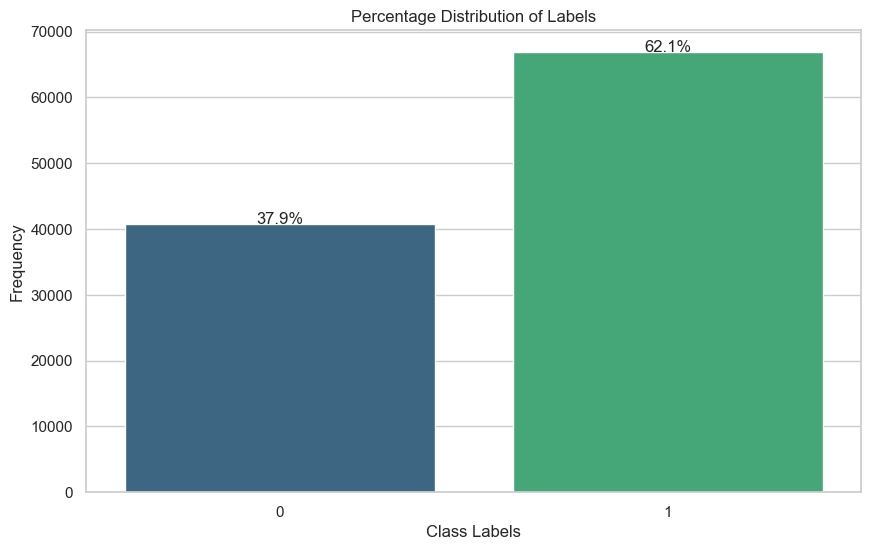

Sum of squared percentages: 0.5294


c:\Users\kimer\Desktop\RandomOdyssey\src\predictionModule\ModelAnalyzer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=label_data, palette=palette)


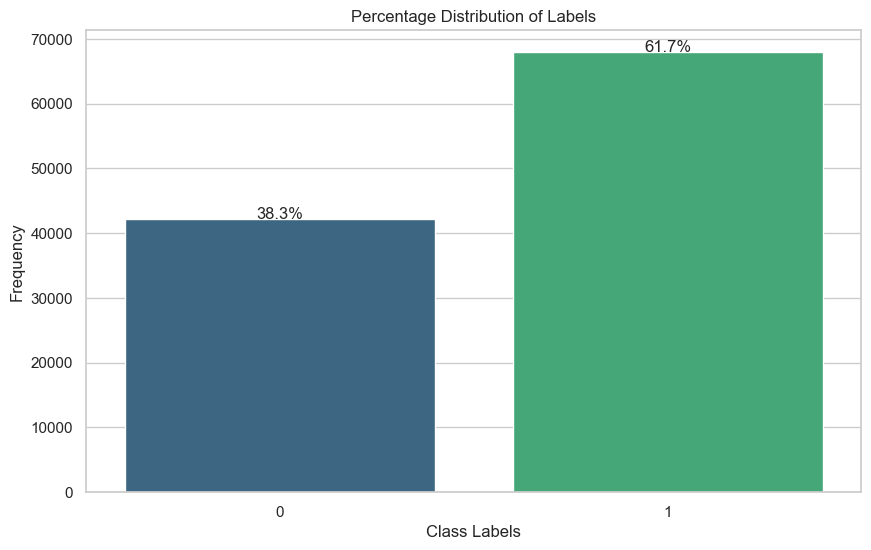

Sum of squared percentages: 0.5273


np.float64(0.5273418550236852)

In [8]:
ma = ModelAnalyzer(nextDayML)
ma.plot_label_distribution(label_data=nextDayML.y_val)

ma = ModelAnalyzer(nextDayML)
ma.plot_label_distribution(label_data=nextDayML.y_test)

In [ ]:
lgbm_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 10,
    'num_leaves': 375,
    'subsample': 1,
    'feature_fraction': 0.1,
    'lambda_l1': 0.1,  # L1 regularization
    'lambda_l2': 0.1,  # L2 regularization
    'min_split_gain': 0.01,
    'n_jobs': -1,
    'early_stopping_round': 100
}
nextDayML.traintestLGBMModel(lgbm_params)

importances = nextDayML.LGBMModel.feature_importances_

y_pred_val = nextDayML.LGBMModel.predict(X_val)
y_pred_proba_val = nextDayML.LGBMModel.predict_proba(X_val)
test_acc_val = accuracy_score(y_val, y_pred_val)
test_loss_val = log_loss(y_val, y_pred_proba_val)

y_pred_test = nextDayML.LGBMModel.predict(X_test)
y_pred_proba_test = nextDayML.LGBMModel.predict_proba(X_test)
test_acc_test = accuracy_score(y_test, y_pred_test)
test_loss_test = log_loss(y_test, y_pred_proba_test)

print(f'Val accuracy: {test_acc_val:.4f}')
print(f'1Test accuracy: {test_acc_test:.4f}')
print(f'Val log loss: {test_loss_val:.4f}')
print(f'Test log loss: {test_loss_test:.4f}')

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 189014, number of negative: 71806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.929288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334454
[LightGBM] [Info] Number of data points in the train set: 260820, nu

In [ ]:
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': nextDayML.featureColumnNames,
    'importance': importances
}).sort_values(by='importance', ascending=False)


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 189014, number of negative: 71806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.586506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326297
[LightGBM] [Info] Number of data points in the train set: 260820, nu

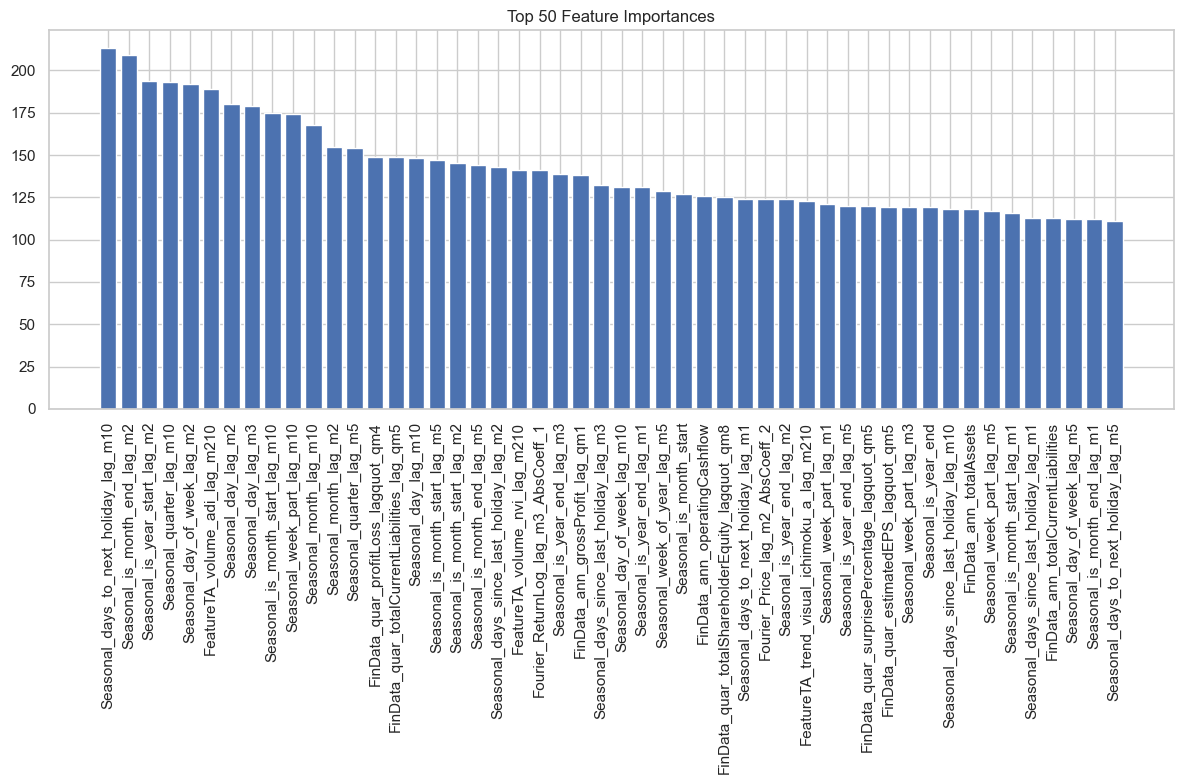

In [11]:
num_features = nextDayML.X_train.shape[1]
features = [f'f{i+1}' for i in range(num_features)]
indices = np.argsort(importances)[::-1][:50]  # Top 50

# Plot top 50 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 50 Feature Importances")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [nextDayML.featureColumnNames[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Select top N features
N = 1500  # for example
top_features = feature_importances['feature'].head(N)
X_train_cropped = X_train[top_features]
X_val_cropped = X_val[top_features]
X_test_cropped = X_test[top_features]

# Retrain with selected features
nextDayML.LGBMModel.fit(X_train_cropped, y_train, eval_set=[(X_val_cropped, y_val)])
y_pred_val = nextDayML.LGBMModel.predict(X_val_cropped)
y_pred_proba_val = nextDayML.LGBMModel.predict_proba(X_val_cropped)
test_acc_val = accuracy_score(y_val, y_pred_val)
test_loss_val = log_loss(y_val, y_pred_proba_val)

y_pred_test = nextDayML.LGBMModel.predict(X_test_cropped)
y_pred_proba_test = nextDayML.LGBMModel.predict_proba(X_test_cropped)
test_acc_test = accuracy_score(y_test, y_pred_test)
test_loss_test = log_loss(y_test, y_pred_proba_test)

print(f'\nVal accuracy: {test_acc_val:.4f}')
print(f'\nTest accuracy: {test_acc_test:.4f}')
print(f'Val log loss: {test_loss_val:.4f}')
print(f'Test log loss: {test_loss_test:.4f}')

In [ ]:
xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.05,
    'n_jobs': -1,
    'early_stopping_round': 100
}
nextDayML.traintestXGBModel(xgb_params)
importances = nextDayML.XGBoostModel

y_pred_val = nextDayML.XGBoostModel.predict(X_val)
y_pred_proba_val = nextDayML.XGBoostModel.predict_proba(X_val)
test_acc_val = accuracy_score(y_val, y_pred_val)
test_loss_val = log_loss(y_val, y_pred_proba_val)

y_pred_test = nextDayML.XGBoostModel.predict(X_test)
y_pred_proba_test = nextDayML.XGBoostModel.predict_proba(X_test)
test_acc_test = accuracy_score(y_test, y_pred_test)
test_loss_test = log_loss(y_test, y_pred_proba_test)

print(f'Val accuracy: {test_acc_val:.4f}')
print(f'Test accuracy: {test_acc_test:.4f}')
print(f'Val log loss: {test_loss_val:.4f}')
print(f'Test log loss: {test_loss_test:.4f}')

c:\Users\kimer\Desktop\RandomOdyssey\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68589
[100]	validation_0-logloss:0.68045
[200]	validation_0-logloss:0.67743
[300]	validation_0-logloss:0.67532
[400]	validation_0-logloss:0.67196
[499]	validation_0-logloss:0.66907
Val accuracy: 0.7044
Test accuracy: 0.6215
Val log loss: 0.5353
Test log loss: 0.6691

Val accuracy: 0.7044

Test accuracy: 0.6215
Val log loss: 0.5353
Test log loss: 0.6691


In [ ]:
import optuna

X_train = (nextDayML.X_train)
y_train = (nextDayML.y_train)
X_test = (nextDayML.X_test)
y_test = (nextDayML.y_test)

def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    lgbm_params = {
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'early_stopping_round': 100,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01, log=True),
    }

    nextDayML.traintestLGBMModel(lgbm_params)
    return nextDayML.metadata['LGBMModel_accuracy_test']

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 20)

y_pred = nextDayML.LGBMModel.predict(nextDayML.X_test)
y_pred_proba = nextDayML.LGBMModel.predict_proba(nextDayML.X_test)

print(accuracy_score(nextDayML.y_test, y_pred))
print(log_loss(nextDayML.y_test, y_pred_proba))

best_trial = study.best_trial
print("Best Trial:")
print(f"  Value (Accuracy): {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
lstm_params = {
    'units': 256,
    'dropout': 0.1,
    'dense_units': 64,
    'activation': 'relu',
    'optimizer': 'adam',
    'loss': 'mean_absolute_error',
    'metrics': ['mae'],
    'epochs': 1000,
    'batch_size': 128,
    'early_stopping_round':30,
}
nextDayML.traintestLSTMModel(lstm_params)
#nextDayML.loadLSTMModel('../src/predictionModule/bin', loadup_name+"_lstmModel")

In [ ]:
ma.plot_lstm_absolute_diff_histogram()

In [18]:
X_test: np.array = nextDayML.X_test_timeseries
y_test: np.array = nextDayML.y_test_timeseries  # shape (:,1)

num_samples, timesteps, num_features = X_test.shape

X_test_flat = X_test.reshape(num_samples, -1)
X_test_scaled_flat = nextDayML.scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(num_samples, timesteps, num_features)

predictions_scaled = nextDayML.LSTMModel.predict(X_test_scaled)
predictions = nextDayML.scaler_y.inverse_transform(predictions_scaled)

876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [19]:
pred_bias = predictions

a=np.array([y_test, pred_bias])
a.reshape(y_test.shape[0],-1)
b=(a.T)[0]

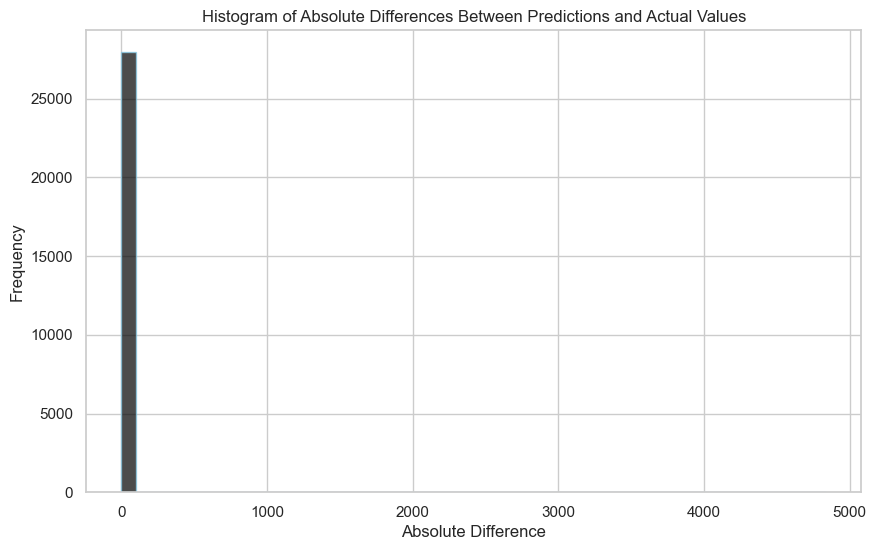

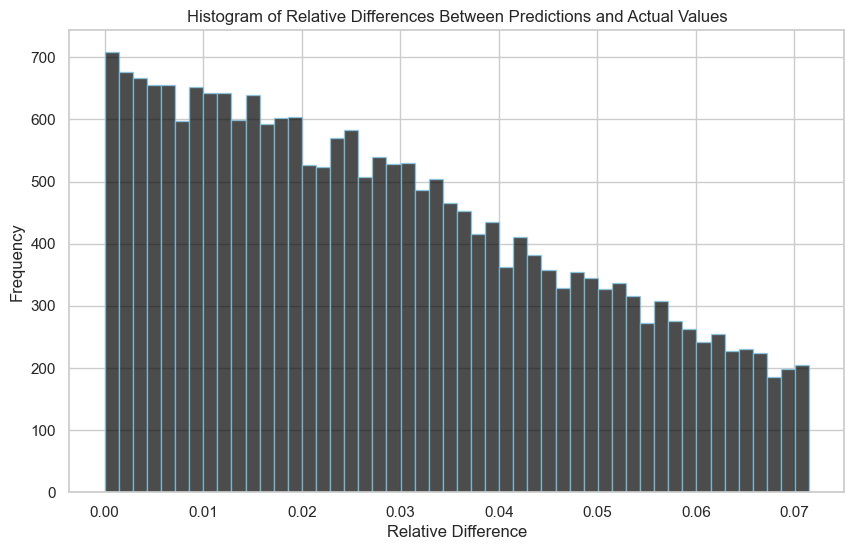

In [26]:
abs_diff = np.abs(pred_bias.flatten() - y_test.flatten())
rel_diff = abs_diff / np.abs(y_test.flatten())

# Filter data to only include the 25th to 75th quantile range
lower_quantile = np.percentile(rel_diff, 0)
upper_quantile = np.percentile(rel_diff, 80)
filtered_rel_diff = rel_diff[(rel_diff >= lower_quantile) & (rel_diff <= upper_quantile)]

# Plot the histogram of absolute differences
plt.figure(figsize=(10,6))
plt.hist(abs_diff, bins=50, color='black', edgecolor='skyblue', alpha=0.7)
plt.title('Histogram of Absolute Differences Between Predictions and Actual Values')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the histogram of relative differences
plt.figure(figsize=(10,6))
plt.hist(filtered_rel_diff, bins=50, color='black', edgecolor='skyblue', alpha=0.7)
plt.title('Histogram of Relative Differences Between Predictions and Actual Values')
plt.xlabel('Relative Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
print(filtered_rel_diff.mean())
print(nextDayML.X_test_timeseries.shape)

0.03479233124944856
(28002, 9, 167)
32.142857142857146


In [27]:
pastprices = nextDayML.X_test_timeseries[:,-1,0]

divPrices = predictions.reshape(-1)/pastprices.reshape(-1)-1

divClass = nextDayML.getTargetFromPrice(np.array(divPrices),nextDayML.classificationInterval)

error = np.abs(divClass-nextDayML.y_test)

c:\Users\kimer\Desktop\RandomOdyssey\src\predictionModule\ModelAnalyzer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=label_data, palette=palette)


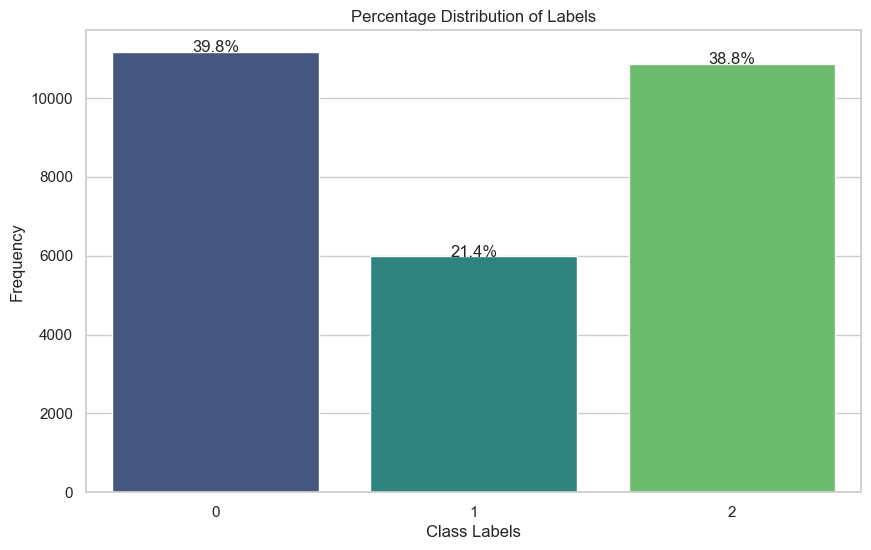

Sum of squared percentages: 0.3549


np.float64(0.3549200172683493)

In [28]:
ma.plot_label_distribution(label_data=error)

Check how likely it is that predition of the return is >3%  then the actual prediction is > 1% as well
We do not explicitly use Bayes' Rule in the calculation. Instead, we used the definition of conditional probability directly.

In [36]:
lastprices = nextDayML.X_test_timeseries[:,-1,0].reshape(-1)
predictions = predictions.reshape(-1)
actualPrice = nextDayML.y_test_timeseries.reshape(-1)

predicted_returns = (predictions - lastprices) / lastprices

# Step 2: Calculate Actual Returns
actual_returns = (actualPrice - lastprices) / lastprices

# Step 3: Apply Conditions
predPerc = 0.5
actualPerc = 0.1
condition_pred_gt_3 = predicted_returns > predPerc
condition_actual_gt_1 = actual_returns > actualPerc

# Number of times predicted return > predPerc
num_pred_gt_3 = np.sum(condition_pred_gt_3)
num_act_gt_3 = np.sum(condition_actual_gt_1)

# Number of times actual return > actualPerc when predicted return > predPerc
num_both_conditions = np.sum(condition_pred_gt_3 & condition_actual_gt_1)

# Step 4: Calculate Probability
if num_pred_gt_3 > 0:
    probability = num_both_conditions / num_pred_gt_3
else:
    probability = 0  # Avoid division by zero if no predictions > 3%

print(num_pred_gt_3)
print(num_both_conditions)
print(num_act_gt_3)
print(f"The probability that the actual return is >{actualPerc} given that the predicted return is >{predPerc} is {probability:.2%}")


32
9
346
The probability that the actual return is >0.1 given that the predicted return is >0.5 is 28.12%
